['30600', '32600', '34600', '36600', '38600', '40600', '42600', '44600', '46600', '48600']


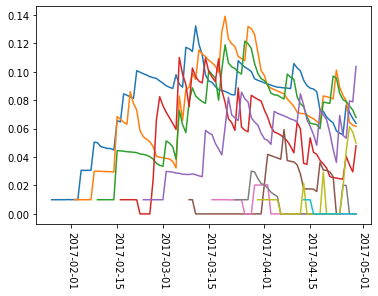

In [46]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt

with h5py.File('SP_LG_Output/track_df.hdf5', 'r') as f:
    track_keys = list(f.keys())
    print(track_keys)
    for key in track_keys:
        data = pd.read_hdf('SP_LG_Output/track_df.hdf5', key=key, mode='r')

        plt.plot(data.index,data['snow_depth'])
    
    plt.xticks(rotation=270)
    
    plt.show()

In [3]:
import numpy as np
import psutil
import time
import pro_utils
import os
import time
from pandas.plotting import register_matplotlib_converters
import SP_utils
import pandas as pd
import dill
from dill import Pickler, Unpickler
import shelve
shelve.Pickler = Pickler
shelve.Unpickler = Unpickler
import smrt_utils
import track_utils
from netCDF4 import Dataset
import logging
import datetime

In [44]:
year = 2016
track_no = 48600

def run_smrt_from_dill(year,track_no):

    output_dir = f"/home/robbie/Dropbox/Modelling/SP_LG/SP_LG_Output/"

    with shelve.open(f'{output_dir}/media_{year}', 'r') as f:

        mediums_list = f[str(track_no)]
    
    print('Running SMRT')
    
    smrt_res = run_media_series(mediums_list, [19e9, 37e9])
    
    print('SMRT run complete')

    smrt_df = process_smrt_results(smrt_res,[19e9, 37e9])

    return(smrt_df)

def combine_smrt_sp_frames(smrt_df,track_no)
    
    SP_df = pd.read_hdf(f'{output_dir}track_df.hdf5', key=str(track_no), mode='r')

    smrt_df['date'] = SP_df.index

    smrt_df.set_index(['date'], inplace=True, drop=True)

    combined = pd.concat([SP_df,smrt_df],axis=1).copy()

    combined.to_hdf(f'{output_dir}track_df_comb.hdf5', key=str(track_no), mode='w')
    
    return(combined)

In [45]:
run_smrt_and_combine(year,track_no)

# Now read the combined result out

comb_res = pd.read_hdf(f'{output_dir}track_df_comb.hdf5', key=str(track_no), mode='r')

comb_res.head()

Running SMRT
SMRT run complete


ValueError: Columns index has to be unique for fixed format

In [19]:
snowpack_data = 

In [28]:
print(snowpack_data.shape)
snowpack_data.head()

(207, 4)


,snow_depth,snow_density,ice_thickness,coords
date,,,,
2016-10-06,0.01,279.0,0.1999,"[-755467.163075, 879082.291]"
2016-10-06,0.01,279.0,0.2077,"[-755467.163075, 879082.291]"
2016-10-07,0.01,279.2,0.2175,"[-758908.5761500001, 880801.2069999998]"
2016-10-08,0.01,239.5,0.2263,"[-762349.9892250001, 882520.1229999998]"
2016-10-09,0.01,238.8,0.2418,"[-765791.4023000002, 884239.0389999998]"


,snow_depth,snow_density,ice_thickness,coords,"Tb(19, 'V')","Tb(37, 'V')","Tb(19, 'H')","Tb(37, 'H')"
date,,,,,,,,
2016-10-06,0.01,279.0,0.1999,"[-755467.163075, 879082.291]",257.004513,259.383169,219.076225,223.789371
2016-10-06,0.01,279.0,0.2077,"[-755467.163075, 879082.291]",259.155645,260.206915,229.035940,230.645840
2016-10-07,0.01,279.2,0.2175,"[-758908.5761500001, 880801.2069999998]",260.022822,260.880168,229.623318,231.075268
2016-10-08,0.01,239.5,0.2263,"[-762349.9892250001, 882520.1229999998]",257.186389,257.898178,226.741630,228.016968
2016-10-09,0.01,238.8,0.2418,"[-765791.4023000002, 884239.0389999998]",258.436814,259.270291,227.566564,229.048008


In [25]:
import numpy as np
import pro_utils
from smrt import make_snowpack, make_ice_column, make_model, sensor_list
import os
import sys
import logging
import itertools
import pandas as pd
# from smrt.utils import dmrt_qms_legacy

def process_smrt_results(smrt_res,frequencies):
    
    dict_of_lists = {}

    if smrt_res != None:

        for pol in ['V', 'H']:
            for freq in frequencies:
                dict_of_lists['Tb'+str((int(freq/1e9),pol))] = smrt_res.Tb_as_dataframe(polarization=pol,frequency=freq)['Tb']

    df = pd.DataFrame(dict_of_lists)

    return(df)



def prep_medium(snowpro,
                brine_inc_corr_len=1.0e-3):

    snow_df, ice_df = snowpro.snowframe, snowpro.iceframe


    # Establish correlation length using Vargel 2020

    SSA = 3/((0.917/2)*np.array(snow_df['optical equivalent grain size (mm)']))
    IVF = np.array(snow_df['ice volume fraction (%)'])/100
    snow_df['CL'] = 4 * np.divide(np.subtract(1, IVF), 917*SSA)

    snowpack = make_snowpack(thickness=snow_df['thickness_m'],

                             temperature=snow_df['element temperature (degC)'] + 273.15,

                             microstructure_model='exponential',

                             corr_length=snow_df['CL'],

                             density=snow_df['element density (kg m-3)'],

                             salinity=snow_df['bulk salinity (g/kg)'] / 1000)

    ice_col = make_ice_column(ice_type='firstyear',
                              thickness=ice_df['thickness_m'],
                              temperature=ice_df['element temperature (degC)'] + 273.15,
                              microstructure_model='exponential',
                              corr_length=np.array([brine_inc_corr_len] * len(ice_df['thickness_m'])),
                              brine_inclusion_shape='spheres',
                              salinity=ice_df['bulk salinity (g/kg)'] / 1000,
                              density=ice_df['element density (kg m-3)'],
                              add_water_substrate='ocean')

    medium = snowpack + ice_col

    return(medium)


def run_media_series(mediums_list,
                 frequencies,
                 solver='dort',
                 angle=55,
                 pol='V'):


    # create the sensor
    radiometer = sensor_list.passive(frequencies, angle, pol)

    n_max_stream = 32  # TB calculation is more accurate if number of streams is increased (currently: default = 32);

    m = make_model("iba", solver,
                   rtsolver_options={"n_max_stream": n_max_stream})

    # run the model for snow-covered sea ice:

    res = m.run(radiometer, mediums_list, progressbar=True)

    # CODE FOR SWITCHING TO DMRT IN EVENT OF DORT FAILURE:
    #
    # try:
    #     if solver == 'dort':
    #         m = make_model("iba", solver,
    #                        rtsolver_options={"n_max_stream": n_max_stream})
    #
    #         # run the model for snow-covered sea ice:
    #
    #         res = m.run(radiometer, mediums_list)
    #     elif solver == 'dmrt_qms':
    #         print('qms')
    #         res = dmrt_qms_legacy.run(radiometer,
    #                                   snowpack,
    #                                   dmrt_qms_path = '/home/robbie/DMRT-QMS/')
    # except:
    #     if solver == 'dort':
    #         logging.warning('Renormalisation failed - forcing...')
    #
    #         m = make_model("iba", solver,
    #                        rtsolver_options={"n_max_stream": n_max_stream,
    #                                          "phase_normalization": 'forced'})
    #
    #         # run the model for snow-covered sea ice:
    #         res = m.run(radiometer, medium)
    #     else:
    #         logging.error('QMS Failed')
    #         return(0)

    return (res)

# if __name__ == '__main__':
#     os.chdir("Snowpack_files")
#     result_list = run_track()
#     print(result_list)